<a href="https://colab.research.google.com/github/Chameleon-company/MOP-Code/blob/Alen_T1_2025/cnn_lstm_sleep_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne wfdb scikit-learn matplotlib numpy pandas


In [2]:
!pip install keras-tuner --quiet


In [3]:
import os
import numpy as np
import pandas as pd
import mne
import wfdb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed,
    Flatten, BatchNormalization, Bidirectional
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [4]:
# Download Sleep-EDF dataset
!mkdir -p sleep-edf
!wget -P sleep-edf https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf
!wget -P sleep-edf https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf



--2025-04-30 08:32:12--  https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48338048 (46M) [application/octet-stream]
Saving to: ‘sleep-edf/SC4001E0-PSG.edf.3’

SC4001E0-PSG.edf.3  100%[===================>]  46.10M   312KB/s    in 2m 23s  

2025-04-30 08:34:35 (330 KB/s) - ‘sleep-edf/SC4001E0-PSG.edf.3’ saved [48338048/48338048]

--2025-04-30 08:34:36--  https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4620 (4.5K) [application/octet-stream]
Saving to: ‘sleep-edf/SC4001EC-Hypnogram.edf.3’

SC4001EC-Hypnogram. 100%[===================>]   4.51K  --.-KB/s    in 0s  

In [9]:
#1

subject_id = "SC4001E0"

# Load EDF files
raw = mne.io.read_raw_edf(f"sleep-edf/{subject_id}-PSG.edf", preload=True)
annotations = mne.read_annotations(f"sleep-edf/{subject_id.replace('E0', 'EC')}-Hypnogram.edf")
raw.set_annotations(annotations)
raw.pick_channels(['EEG Fpz-Cz'])

# Convert annotations to epochs
events, event_id = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=30, baseline=None, preload=True)
data = epochs.get_data()

# Label Mapping
stage_map = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}
event_labels = [k for k in event_id.keys() if k.startswith("Sleep stage") and "?" not in k]
label_lookup = {event_id[label]: stage_map[label] for label in event_labels if label in stage_map}
labels = np.array([label_lookup[e[-1]] for e in events[:len(data)]])


Extracting EDF parameters from /content/sleep-edf/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<ipython-input-9-01ebab9f76de>:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(f"sleep-edf/{subject_id}-PSG.edf", preload=True)
<ipython-input-9-01ebab9f76de>:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(f"sleep-edf/{subject_id}-PSG.edf", preload=True)
<ipython-input-9-01ebab9f76de>:6: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(f"sleep-edf/{subject_id}-PSG.edf", preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
154 matching events found


<ipython-input-9-01ebab9f76de>:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 3001 original time points ...
1 bad epochs dropped


In [11]:
# Normalize globally
X = data.squeeze()
global_mean = np.mean(X)
global_std = np.std(X)
X_normalized = (X - global_mean) / global_std

# ✅ Trim samples to 3000 points each
X_trimmed = np.array([x[:3000] for x in X_normalized if len(x) >= 3000])

# ✅ Reshape into (samples, time steps, features)
X = X_trimmed.reshape((X_trimmed.shape[0], 3000, 1))  # e.g., (153, 3000, 1)

# Align labels
labels = labels[:len(X)]
y = to_categorical(labels, num_classes=5)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [12]:
def build_fixed_model(input_shape=(3000, 1), learning_rate=0.0003):
    model = Sequential([
        Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model





In [13]:
#6
# ✅ Correct reshape for input_shape = (3000, 1)
X_train = X_train.reshape((-1, 3000, 1))
X_test = X_test.reshape((-1, 3000, 1))




In [14]:
print("X_train shape:", X_train.shape)   # ✅ should be (samples, 3000, 1)
print("y_train shape:", y_train.shape)   # ✅ should be (samples, 5)


X_train shape: (122, 3000, 1)
y_train shape: (122, 5)


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3
)


In [20]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Build model
model = build_fixed_model()

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3309 - loss: 1.5940 - val_accuracy: 0.4800 - val_loss: 1.5562 - learning_rate: 3.0000e-04
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 538ms/step - accuracy: 0.3516 - loss: 1.5746 - val_accuracy: 0.4800 - val_loss: 1.5293 - learning_rate: 3.0000e-04
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - accuracy: 0.4109 - loss: 1.5418 - val_accuracy: 0.4800 - val_loss: 1.5038 - learning_rate: 3.0000e-04
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 919ms/step - accuracy: 0.4555 - loss: 1.5250 - val_accuracy: 0.4800 - val_loss: 1.4781 - learning_rate: 3.0000e-04
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 538ms/step - accuracy: 0.4449 - loss: 1.5059 - val_accuracy: 0.4800 - val_loss: 1.4479 - learning_rate: 3.0000e-04
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - accuracy: 0.4388 - loss: 1.4695 - val_accuracy: 0.4800 - val_loss: 1.4142 - learning_rate: 3.0000e-04
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - accuracy: 0.4617 - loss: 1.


✅ Test Accuracy: 0.52
✅ Test Loss: 1.1311
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   

✅ Macro F1 Score: 0.1702

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.00      0.00      0.00         0
          N1       0.00      0.00      0.00         4
          N2       0.00      0.00      0.00        10
          N3       0.52      1.00      0.68        16
         REM       0.00      0.00      0.00         1

    accuracy                           0.52        31
   macro avg       0.10      0.20      0.14        31
weighted avg       0.27      0.52      0.35        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

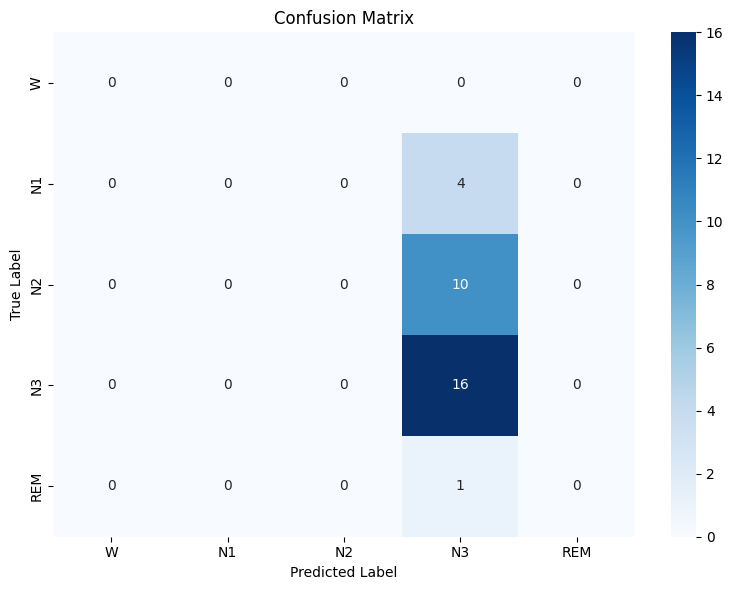

In [21]:
#8
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {accuracy:.2f}")
print(f"✅ Test Loss: {loss:.4f}")

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# F1 Score
f1 = f1_score(y_true, y_pred, average='macro')
print(f"\n✅ Macro F1 Score: {f1:.4f}")

# Classification report
target_names = ["W", "N1", "N2", "N3", "REM"]
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, labels=[0, 1, 2, 3, 4], target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
